In [1]:
import glob
import math
import os
import cv2
import sys
import traceback
from PIL import Image
import scipy.ndimage
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import skimage.filters
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera class

In [2]:
class Camera:

    def __init__(self, calibration_src):
        self.objpoints, self.imgpoints = self.__find_camera_distortion_mapping(calibration_src)
        self.image_shape = (1280, 720)
        w,h = self.image_shape
        x,y = 0.5*w, 0.8*h
        
        if False:
            self.src = np.float32([[200./1280*w,720./720*h],
                          [453./1280*w,547./720*h],
                          [835./1280*w,547./720*h],
                          [1100./1280*w,720./720*h]])
            self.dst = np.float32([[(w-x)/2.,h],
                          [(w-x)/2.,0.82*h],
                          [(w+x)/2.,0.82*h],
                          [(w+x)/2.,h]])

        self.src = np.array([[(189, 720),
                              (590, 450),
                              (689, 450),
                              (1135, 720)
                              ]], dtype=np.float32)

        self.dst = np.array([[(315, 720),
                              (315, 0),
                              (960, 0),
                              (960, 720)
                              ]], dtype=np.float32)
        
        self.inter_right = np.array([[(315, 720),
                              (950,385),
                              (1591,385),
                              (960, 720)
                              ]], dtype=np.float32)
        
        self.inter_left = np.array([[(315, 720),
                              (-320, 385),
                              (329, 385),
                              (960, 720)
                              ]], dtype=np.float32)
       
        
        self.bird_view_image_size = (1280, 720)

        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
        self.M_left = cv2.getPerspectiveTransform(self.inter_left, self.dst)
        self.Minv_left = cv2.getPerspectiveTransform(self.dst, self.inter_left)
        
        self.M_right = cv2.getPerspectiveTransform(self.inter_right, self.dst) 
        self.Minv_right = cv2.getPerspectiveTransform(self.dst, self.inter_right)
        
        self.ym_per_pix = 30 / 720  # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
        
        ret, mtx, dist, rvecs, tvecs = \
            cv2.calibrateCamera(self.objpoints, self.imgpoints, self.image_shape, None, None)
            
        self.mtx = mtx
        self.dist = dist

    def __find_camera_distortion_mapping(self, src):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6 * 9, 3), np.float32)
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = []  # 3d points in real world space
        imgpoints = []  # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob(src + '/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for i, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

            # If found, add object points, image points
            if ret :
                objpoints.append(objp)
                imgpoints.append(corners)

        return objpoints, imgpoints

    def cal_undistort(self, img):
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist

    def transform_to_bird_view(self, image):
        warped = cv2.warpPerspective(image, self.M, self.bird_view_image_size)
        return warped

    def transform_to_camera_view(self, image):
        warped = cv2.warpPerspective(image, self.Minv, self.image_shape)
        return warped
    
    def transform_further_point_inv(self, points, direction):
        if points is None:
            return points
        
        if(direction > 0):
            tpoints = cv2.perspectiveTransform(np.array([points], dtype='float32'), self.Minv_right)
            tpoints = np.squeeze(tpoints, axis=0).astype(int)
        elif(direction < 0):
            tpoints = cv2.perspectiveTransform(np.array([points], dtype='float32'), self.Minv_left)
            tpoints = np.squeeze(tpoints, axis=0).astype(int)
        else:
            tpoints = points
            
        return tpoints
    
    def transform_further(self, image, direction): 
        if(direction > 0):
            warped = cv2.warpPerspective(image, self.M_right, self.bird_view_image_size)
        elif(direction < 0):
            warped = cv2.warpPerspective(image, self.M_left, self.bird_view_image_size)
        else:
            warped = np.copy(image)
            
        return warped
            
    def transform_further_inverse(self, image, direction): 
        if(direction > 0):
            warped = cv2.warpPerspective(image, self.Minv_right, self.bird_view_image_size)
        elif(direction < 0):
            warped = cv2.warpPerspective(image, self.Minv_left, self.bird_view_image_size)
        else:
            warped = np.copy(image)
            
        return wraped

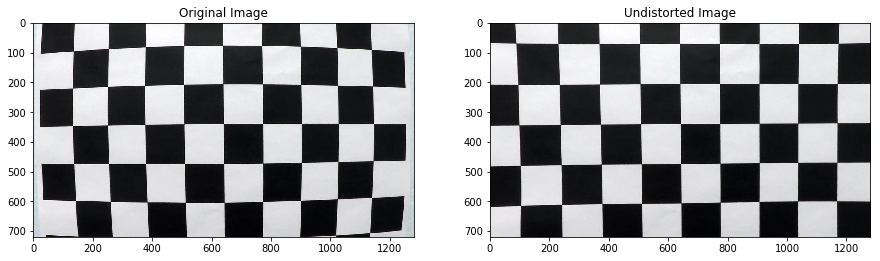

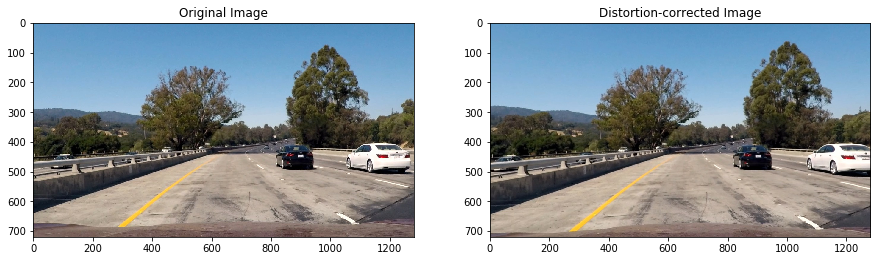

In [3]:
camera = Camera('./camera_cal')
image_checkboard = cv2.imread('./camera_cal/calibration1.jpg')
undist_checkboard = camera.cal_undistort(image_checkboard)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

axarr[0].set_title("Original Image")
axarr[0].imshow(image_checkboard)

axarr[1].set_title("Undistorted Image")
axarr[1].imshow(undist_checkboard)

plt.show()

image_test1 = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
undist_test1 = camera.cal_undistort(image_test1)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

axarr[0].set_title("Original Image")
axarr[0].imshow(image_test1)

axarr[1].set_title("Distortion-corrected Image")
axarr[1].imshow(undist_test1)

plt.show()

## Road feature detection

In [18]:
class RoadFeatureDetector:

    class RoadFeatureDetectorParameter:
        def __init__(self):
            #Change your configuration here

            #image
            self.image = None
            self.image_yuv = None
            self.image_hsv = None
            self.image_lab = None
            self.image_enhanced = None
            self.image_enhanced_yuv = None
            self.image_enhanced_hsv = None
            self.image_enhanced_lab = None

            #MASKING
            #image related
            self.lower_half_start_y = 450
            self.near_car_start_y = 600
            #road detection
            self.road_color_diff = 30 #15
            self.road_closing_size = 70
            self.road_dilate_size = 60 #10
            #mask related
            self.enable_color_mask = False
            self.mask_dilate = 9
            # remove non-line setting
            self.non_line_closing_size = 13
            self.non_line_opening_size = 60

            # FEATURE EXTRACTION
            #sobel absolute
            self.abs_sobel_direction = 'x'
            self.abs_sobel_low_threshold = 20
            self.abs_sobel_high_threshold = 100
            self.sobel_guassian_blur = 13
            # sobel magnitude
            self.abs_sobel_mag_threshold = 0
            self.abs_sobel_mag_kernel = 255
            # sobel direction
            self.abs_sobel_dir_threshold = 0
            self.abs_sobel_dir_kernel = np.pi / 2
            # hsl detection
            self.hsl_threshold = (0, 255)
            #yellow detection
            self.yellow_lower = 155
            self.yellow_upper = 200
            #white detection
            self.white_intensity_threshold = None
            self.white_intensity_threshold_low = None
            #feature enable/disable
            self.enable_hist_eq = False
            
            ##OUTPUT
            self.output_mask_road = None
            self.output_mask_yellow = None
            self.output_mask_white = None
            self.output_mask_edge = None
            self.output_mask_combined = None

            self.output_feature_yellow = None
            self.output_feature_white = None
            self.output_feature_edge = None
            self.output_masked_feature = None

    def __init__(self):
        self.debug_dict = None
        self.debug_flag = False

    # Define a function that applies Sobel x or y,
    # then takes an absolute value and applies a threshold.
    # Note: calling your function with orient='x', thresh_min=5, thresh_max=100
    # should produce output like the example image shown above this quiz.
    def __abs_sobel_thresh(self, image_gray, orient='x', thresh_min=0, thresh_max=255, guassian_blur=13):
        gray = cv2.GaussianBlur(image_gray, (guassian_blur, guassian_blur), 0)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
            if orient == 'y':
                abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
            # Rescale back to 8 bit integer
            scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
            # Create a copy and apply the threshold
            binary_output = np.zeros_like(scaled_sobel)
            # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
            binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

            return binary_output


    # Define a function that applies Sobel x and y,
    # then computes the magnitude of the gradient
    # and applies a threshold
    def __mag_thresh(self, image_gray, sobel_kernel=3, mag_thresh=(0, 255)):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        sobelx = (cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        sobely = (cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

        return binary_output


    # Define a function that applies Sobel x and y,
    # then computes the direction of the gradient
    # and applies a threshold.
    def __dir_threshold(self, image_gray, sobel_kernel=3, thresh=(0, np.pi / 2)):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        sobelx = np.absolute(cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        sobely = np.absolute(cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        mag_sobel = np.arctan2(sobely, sobelx)
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(mag_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(mag_sobel >= thresh[0]) & (mag_sobel <= thresh[1])] = 1

        return binary_output


    # Define a function that thresholds the S-channel of HLS
    # Use exclusive lower bound (>) and inclusive upper (<=)
    def __hls_select(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:, :, 2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

        return binary_output

    def __yellow_color(self, image_lab, lower_yellow, upper_yellow, dilate_kernel_size):
        b_channel = image_lab[:,:,2]
        # Threshold the HSV image to get only yellow colors
        mask = np.zeros_like(b_channel, dtype=np.uint8)

        mask[(b_channel >= lower_yellow) & (b_channel <= upper_yellow)] = 1

        if(dilate_kernel_size > 0):
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate_kernel_size, dilate_kernel_size))
            mask = cv2.dilate(mask, kernel, iterations=1)
        
        mask[mask > 0] = 1

        return mask

    def __white_color(self, image_lab, lower_white, dilate_kernel_size):
        l_channel = image_lab[:,:,0]
        mask = np.zeros_like(l_channel, dtype=np.uint8)

        mask[(l_channel >= lower_white) & (l_channel <= 255)] = 1
        
        if(dilate_kernel_size > 0):
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate_kernel_size, dilate_kernel_size))
            mask = cv2.dilate(mask, kernel, iterations=1)
            
        mask[mask > 0] = 1

        return mask

    def __highlight_horizontal_line(self, image):
        def adoptive_canny(img, threshold):
            ret,thresh1 = cv2.threshold(img , 0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU);
            cannyThresh = threshold * ret;
            return cv2.Canny(img,cannyThresh,ret);

        img_canny = adoptive_canny(image, 5)
        img_ver = skimage.filters.sobel_v(img_canny)
        img_ver = np.abs(img_ver) * 255

        return img_ver
    
    def remove_non_line_structure(self, image):
        process_param = self.RoadFeatureDetectorParameter()
        
        return self.__remove_non_line_structure(image, process_param.non_line_closing_size, process_param.non_line_opening_size)
        
    def __remove_non_line_structure(self, image, close_ksize, open_ksize):
        ckernel = cv2.getStructuringElement(cv2.MORPH_RECT,(close_ksize,close_ksize))
        okernel = cv2.getStructuringElement(cv2.MORPH_RECT,(open_ksize,open_ksize))

        image_close = cv2.morphologyEx(image, cv2.MORPH_CLOSE, ckernel)
        image_open = cv2.morphologyEx(image_close, cv2.MORPH_OPEN, okernel)
        final_img = np.zeros_like(image_close, dtype=np.uint8)
        final_img[(image > 0) & (image_open==0)]=1

        return final_img

    def __percentile(self, data, percentile):
        size = len(data)
        return data[int(math.ceil((size * percentile) / 100)) - 1]
    
    def __gary_road_detector_helper(self, image_hsv, seed, road_color_diff, \
                             road_closing_size, road_dilate_size):
        hsv = image_hsv
        h,w = hsv.shape[:-1]
        img_x = np.zeros_like(hsv[:,:,0])
        
        mask = np.ones_like(hsv[:,:,1], dtype=np.uint8)
        mask[(hsv[:,:,1] > 90) & (hsv[:,:,2] > 60)] = 0
        mask[hsv[:,:,2] > 225] = 0
        
        h_channel = image_hsv[:,:,0]
        s_channel = image_hsv[:,:,1]
        
        base_h = h_channel[seed[1], seed[0]]
        base_s = s_channel[seed[1], seed[0]]
        min_th_h, max_th_h = max(0, base_h-road_color_diff),  min(255, base_h+road_color_diff)
        min_th_s, max_th_s = max(0, base_s-road_color_diff),  min(255, base_s+road_color_diff)
        
        img_x[(mask == 1) & 
              (((h_channel >= min_th_h) & (h_channel <= max_th_h)) |
              ((s_channel >= min_th_s) & (s_channel <= max_th_s))) ] = 1
        
        mask = np.zeros((h+2,w+2),np.uint8)
        mask[0,:] = 1
        mask[:,0] = 1
        mask[h+1, :] = 1
        mask[:, w+1] = 1
        
        floodflags = 4
        num,im,mask,rect = cv2.floodFill(img_x, mask, seed, 255, 0, 0, floodflags)
        im[(im!= 255)] = 0
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (road_dilate_size, road_dilate_size))
        im = cv2.dilate(im, kernel, iterations=1)
        im[im > 0]=1
        
        return im
    
    def __gray_road_detector(self, seeds, image_hsv, road_color_diff, \
                             road_closing_size, road_dilate_size):
        #TODO: testing
        #image_hsv = cv2.cvtColor(cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2HLS)
        h,w = image_hsv.shape[:-1]
        
        im = np.zeros((h, w),np.uint8)
        for seed in seeds:
            im_t = self.__gary_road_detector_helper(image_hsv, seed, road_color_diff, \
                             road_closing_size, road_dilate_size)
            im[im_t == 1] = 1
        
        return im

    def __equalize_intensity(self, image):
        ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb);
        channels = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        channels[0] = clahe.apply(channels[0])

        ycrcb = cv2.merge(channels)

        result = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

        return result

    def __create_mask(self, param):
        h,w = param.image_hsv.shape[:-1]
        seeds = [(w//2,h*6//8), (w*8//20,h*7//8), 
                 (w*9//20,h*7//8), (w*12//20, h*7//8), (w*11//20,h*7//8)]
        g_binary = self.__gray_road_detector(seeds, param.image_hsv, param.road_color_diff,
                                             param.road_closing_size, param.road_dilate_size)
        
        param.white_intensity_threshold, param.white_intensity_threshold_low \
            = self.__find_white_threshold(g_binary, param.image_enhanced_lab[:,:,0])
        #param.white_intensity_threshold = min(param.white_intensity_threshold, 225)
        
        param.output_mask_road = g_binary
        
        mask_clr = g_binary
            
        if self.debug_flag:
            debug_image = np.dstack(( np.zeros_like(g_binary), g_binary, np.zeros_like(g_binary))) * 255
            for seed in seeds:
                cv2.circle(debug_image, seed, 5, (0,0,255), -1)
                        
            nonzero_ptg= len(debug_image.nonzero()[0]) * 1.0 / debug_image.size * 100
            cv2.putText(debug_image, "COVER PERCENTAGE: %d%%" % nonzero_ptg, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2,
                        cv2.LINE_AA)
            
            self.debug_dict['mask'] = debug_image
            
        return mask_clr

    def __create_feature(self, param):
        #denoise_image = cv2.fastNlMeansDenoising(param.image_yuv[:,:,0],None,10,7,21)
        #denoise_image = cv2.GaussianBlur(param.image_yuv[:,:,0], (15, 15), 0)
        #denoise_image = cv2.bilateralFilter(param.image_yuv[:,:,0],15,75,75)
        denoise_image = param.image_yuv[:,:,0]
        sxbinary = self.__abs_sobel_thresh(denoise_image, param.abs_sobel_direction,
                                           param.abs_sobel_low_threshold, param.abs_sobel_high_threshold)
        s_yellow = self.__yellow_color(param.image_enhanced_lab, param.yellow_lower, param.yellow_upper, 0)
        
        #lower_white = min(param.white_intensity_threshold, 225)
        s_white = self.__white_color(param.image_enhanced_lab, param.white_intensity_threshold, 0)
        if np.count_nonzero(s_white) > np.size(param.image_yuv[:,:,0]) * 0.05 :
            s_white = np.zeros_like(param.image_yuv[:,:,0])

        #if param.remove_nonline_in_feature:
        #    sxbinary = self.__remove_non_line_structure(sxbinary, param.non_line_closing_size, param.non_line_opening_size)
        #    s_yellow = self.__remove_non_line_structure(s_yellow, param.non_line_closing_size, param.non_line_opening_size)
        #    s_white = self.__remove_non_line_structure(s_white, param.non_line_closing_size, param.non_line_opening_size)
        
        # Combine the two binary thresholds
        combined_feature = np.zeros_like(s_yellow)
        combined_feature[(s_yellow == 1) | (sxbinary == 1) | (s_white == 1)] = 1

        param.output_feature_yellow = s_yellow
        param.output_feature_white = s_white
        param.output_feature_edge = sxbinary

        return combined_feature

    def __is_masking_good(self, mask):
        # Choose the number of sliding windows
        nwindows = 6
        minpix = 25
        # Set height of windows
        window_height = np.int(mask.shape[0] / nwindows)

        nonzero = mask.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bad_window_score = 0

        for window in range(nwindows):
            win_y_low = mask.shape[0] - (window + 1) * window_height
            win_y_high = mask.shape[0] - window * window_height
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

            if (len(good_inds) < minpix):
                bad_window_score = bad_window_score + window #close to base have a heavier weighting

        return bad_window_score > 5

    def __find_white_threshold(self, road_mask, image_gray):
        data = image_gray[image_gray.nonzero()].ravel()
        data = np.sort(data)
        thresh = min(self.__percentile(data, 99)+1, 255)
        thresh_low = min(self.__percentile(data, 97)+1, 255)
        
        return thresh, thresh_low
    
    def collect_road_features(self, image):
        self.debug_dict = {}
        process_param = self.RoadFeatureDetectorParameter()
        
        if process_param.enable_hist_eq:
            image_enhanced = self.__equalize_intensity(image)
        else:
            image_enhanced = image

        process_param.image = image
        process_param.image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        process_param.image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        process_param.image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
        process_param.image_enhanced = image_enhanced
        process_param.image_enhanced_yuv = cv2.cvtColor(image_enhanced, cv2.COLOR_RGB2YUV)
        process_param.image_enhanced_hsv = cv2.cvtColor(image_enhanced, cv2.COLOR_RGB2HSV)
        process_param.image_enhanced_lab = cv2.cvtColor(image_enhanced, cv2.COLOR_RGB2LAB)

        mask = self.__create_mask(process_param)
        color = self.__create_feature(process_param)

        self.debug_dict['enhanced'] = image_enhanced
        
        process_param.output_feature_yellow[(mask == 0)] = 0
        process_param.output_feature_white[(mask == 0)] = 0
        process_param.output_feature_edge[(mask == 0)] = 0
        
        return process_param.output_feature_edge, process_param.output_feature_white, process_param.output_feature_yellow

    def get_debug_info(self):
        return self.debug_dict;


## Lane definition

In [5]:
class Lane:
    def __init__(self, polyfit):
        self.polyfit = polyfit

    def set_lane_line_pixel(self, pixels):
        self.pixels = pixels

    def set_lane_line_detection_windows(self, windows_pos, is_windows_good):
        self.window_pos = windows_pos
        self.is_windows_good = is_windows_good

    def calc_real_scale(self, ym_per_pix, xm_per_pix):
        self.polyfit_real_scale = np.zeros(self.polyfit.shape)

        self.polyfit_real_scale[0] = self.polyfit[0] / ym_per_pix / ym_per_pix * xm_per_pix
        self.polyfit_real_scale[1] = self.polyfit[1] / ym_per_pix * xm_per_pix
        self.polyfit_real_scale[2] = self.polyfit[2] * xm_per_pix

        return self.polyfit_real_scale

    def line_base_real_scale(self, y):
        return self.polyfit_real_scale[0] * y ** 2 + self.polyfit_real_scale[1] * y + self.polyfit_real_scale[2]

    def line_curvature_real_scale(self, y):
        ''' y is the real scale in bird view'''
        return ((1 + (2 * self.polyfit_real_scale[0] * y + self.polyfit_real_scale[1]) ** 2) ** 1.5) / np.absolute(
            2 * self.polyfit_real_scale[0])

    def line_x_pos(self, y):
        return self.polyfit[0] * y ** 2 + self.polyfit[1] * y + self.polyfit[2]

    def line_curvature(self, y):
        ''' y is the real scale in bird view'''
        return ((1 + (2 * self.polyfit[0] * y + self.polyfit[1]) ** 2) ** 1.5) / np.absolute(
            2 * self.polyfit[0])

    def error_rate(self):
        if self.is_windows_good is None:
            return 0
        else: 
            return np.count_nonzero(self.is_windows_good == False) / len(self.is_windows_good)

## Lane detection

In [27]:
class LaneDetectorParam():
    def __init__(self):
        self.image_shape = None
        self.find_lane_left_lane_pos = 310
        self.find_lane_right_lane_pos = 960
        self.find_lane_lane_sigma = 200
        self.find_lane_no_detect_window_y = 15
        self.find_lane_window_margin_x = 100
        self.find_lane_min_pixel = 300 #30
        self.find_lane_weighting = lambda norm_x, norm_y: norm_y ** 2
        self.camera_dir = './camera_cal'
        #remove non-line in features
        self.remove_nonline_in_feature = True
        # pixel property weighting
        self.yellow_pixel_weighting = 5
        self.white_pixel_weighting = 2
        self.edge_pixel_weighting = 1
        
class LaneDetector():

    def __init__(self):
        self.param = LaneDetectorParam()
        self.camera = Camera(self.param.camera_dir)
        self.road_feature_detector = RoadFeatureDetector()
        self.__debug_flag = False
        self.__debug_dict = None
        self.exp_lane_width_meter =3.7

    def set_debug_flag(self, value):
        self.__debug_flag = value
        self.camera.debug_flag = value
        self.road_feature_detector.debug_flag = value

    def __birdview_pixel_weighting(self, shape, left_lane_base, right_lane_base, y_dist_max, y_dist_w, sigma):
        x_left = norm(loc=left_lane_base, scale=sigma)
        x_right = norm(loc=right_lane_base, scale=sigma)
        x_idx = np.arange(0, shape[0], 1)
        x = (x_left.pdf(x_idx) + x_right.pdf(x_idx)) / (0.3989 / sigma) * 4
        y = np.append(np.zeros(y_dist_max), np.linspace(1, y_dist_w, shape[1] - y_dist_max))
        xv, yv = np.meshgrid(x, y)
        result = xv * yv

        np.clip(result, 0, 255, out=result)
        return result.astype(np.uint8)

    def __draw_histogram(self, histogram, remarks=""):
        fig = Figure(figsize=(3, 1))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        canvas = FigureCanvas(fig)
        ax = fig.gca()

        ax.plot(histogram)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        canvas.draw()  # draw the canvas, cache the renderer

        width, height = fig.get_size_inches() * fig.get_dpi()
        image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
        
        cv2.putText(image, remarks, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
        
        return image
    
    def __find_left_and_right_base_fix_width(self, binary_warped, spacing, left_lane, right_lane, lane_sigma):
        shape = binary_warped.shape[1::-1]
        weights = self.__birdview_pixel_weighting(shape, left_lane, right_lane, shape[1] // 2, 3, lane_sigma)
        weighted_binary_warped = binary_warped 
        
        histogram_50 = np.sum(weighted_binary_warped[weighted_binary_warped.shape[0] // 2:, :], axis=0)
        histogram_25 = np.sum(weighted_binary_warped[weighted_binary_warped.shape[0] * 3 // 4 :, :], axis=0)
        
        histogram = histogram_50 + histogram_25 * 2
        
        midpoint = np.int(histogram_50.shape[0] // 2)
        leftx_base = (np.argmax(histogram_50[:midpoint]) + np.argmax(histogram_25[:midpoint]) *2)//3
        rightx_base = (np.argmax(histogram_50[midpoint:]) + np.argmax(histogram_25[midpoint:]) * 2)//3 + midpoint
        
        rightx_base_st = int(leftx_base + spacing * 0.7)
        rightx_base_2 = (np.argmax(histogram_50[rightx_base_st:]) 
                         + np.argmax(histogram_25[rightx_base_st:]) * 2)//3 + rightx_base_st
        
        leftx_base_st = int(rightx_base - spacing * 0.7)
        leftx_base_2 = (np.argmax(histogram_50[:leftx_base_st]) + np.argmax(histogram_25[:leftx_base_st]) * 2)//3
        
        if(self.__debug_flag):
            self.__debug_dict['histogram'] = self.__draw_histogram(histogram, "FIX W")
        
        if(max(histogram[leftx_base], histogram[rightx_base_2]) > max(histogram[leftx_base_2], histogram[rightx_base])):
            return leftx_base, rightx_base_2
        else:
            return leftx_base_2, rightx_base
        
    def __find_left_and_right_base_conv(self, binary_warped, window, left_lane, right_lane, lane_sigma): 
        shape = binary_warped.shape[1::-1]
        window_width = len(window)
        weights = self.__birdview_pixel_weighting(shape, left_lane, right_lane, shape[1] // 2, 3, lane_sigma)
        weighted_binary_warped = weights * binary_warped
        # Sum quarter bottom of image to get slice, could use a different ratio
        histogram = np.sum(binary_warped[int(3*weighted_binary_warped.shape[0]/4):,:], axis=0)
        
        l_sum = histogram[:int(weighted_binary_warped.shape[1]/2)]
        l_center = np.argmax(np.convolve(window,l_sum))-window_width//2
        r_sum = histogram[int(weighted_binary_warped.shape[1]/2):]
        r_center = np.argmax(np.convolve(window,r_sum))-window_width//2+int(weighted_binary_warped.shape[1]/2)
        
        if(self.__debug_flag):
            self.__debug_dict['histogram'] = self.__draw_histogram(histogram, "CONV")
        
        return l_center, r_center
    
    def create_reorder_array(self, min_index, max_index):
        mid = (max_index - min_index)//2
        result = np.zeros(max_index - min_index, dtype=np.int)
        left = np.arange(0, mid)
        left = left[::-1]
        right = np.arange(mid, max_index - min_index)
        result[0::2] = right
        result[1::2] = left

        return np.array(result)
    
    def __find_left_and_right_lane_conv(self, binary_warped, weighting_func, left_lane = 310, right_lane = 960, lane_sigma = 200,
                                   no_detect_window_y = 27, window_margin_x = 100, min_pixel = 20, direction = 0):
        # transform the image here given the hints
        binary_warped = self.camera.transform_further(binary_warped, direction)
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        window_width = 50 
        window_height = np.int(binary_warped.shape[0] / no_detect_window_y)
        margin = window_margin_x
        minpix = min_pixel

        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        l_center, r_center = self.__find_left_and_right_base_conv(binary_warped, window, left_lane, right_lane, lane_sigma)
        
        exp_spacing = int(self.exp_lane_width_meter / self.camera.xm_per_pix)
        if abs(l_center - r_center) < exp_spacing * 0.75 or abs(l_center - r_center) > exp_spacing:
            l_center, r_center = self.__find_left_and_right_base_fix_width(binary_warped, exp_spacing, left_lane, right_lane, lane_sigma)
        
        left_lane_inds = []
        right_lane_inds = []
        left_windows = []
        right_windows = []
        is_left_window_good = []
        is_right_window_good = []
        leftw = []
        rightw = []
        consecutive_bad_left = 0
        consecutive_bad_right = 0
        current_leftw = 1
        current_rightw = 1
        
        win_y_low = int(binary_warped.shape[0]-window_height)
        win_y_high = int(binary_warped.shape[0])
        win_xleft_low = l_center - window_width//2
        win_xleft_high  = l_center + window_width//2
        win_xright_low = r_center - window_width//2
        win_xright_high = r_center + window_width//2
        left_windows.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high))
        right_windows.append((win_xright_low, win_y_low, win_xright_high, win_y_high))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(binary_warped.shape[0]/window_height)):
            win_y_low = int(binary_warped.shape[0]-(level+1)*window_height)
            win_y_high = int(binary_warped.shape[0]-level*window_height)
            
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width//2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
            l_order = self.create_reorder_array(l_min_index, l_max_index)
            l_conv_signal = (conv_signal[l_min_index:l_max_index])[l_order]
            l_center_t = np.argmax(l_conv_signal)
            l_center_t = l_order[l_center_t]+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
            r_order = self.create_reorder_array(r_min_index, r_max_index)
            r_conv_signal = (conv_signal[r_min_index:r_max_index])[r_order]
            r_center_t = np.argmax(r_conv_signal)
            r_center_t = r_order[r_center_t]+r_min_index-offset
            
            # Identify the nonzero pixels in x and y within the window
            
            win_xleft_low = l_center_t - offset
            win_xleft_high  = l_center_t + offset
            win_xright_low = r_center_t - offset
            win_xright_high = r_center_t + offset
            
            left_windows.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high))
            right_windows.append((win_xright_low, win_y_low, win_xright_high, win_y_high))
            
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                is_left_window_good.append(True)
                l_center = l_center_t
                consecutive_bad_left = 0
            else:
                is_left_window_good.append(False)
                consecutive_bad_left = consecutive_bad_left + 1
            
            if len(good_right_inds) > minpix:   
                is_right_window_good.append(True)
                r_center = r_center_t
                consecutive_bad_right = 0
            else:
                is_right_window_good.append(False)
                consecutive_bad_right = consecutive_bad_right + 1
            
            # early closing
            if(consecutive_bad_left == 1 and
               (l_center < 1.5 * window_width or l_center > binary_warped.shape[1] - 1.5 * window_width)):
                current_leftw = 0
            if(consecutive_bad_right == 1 and
               (r_center < 1.5 * window_width or r_center > binary_warped.shape[1] - 1.5 * window_width)):
                current_rightw = 0
                
            if(consecutive_bad_left == 2):
                current_leftw = current_leftw / 2
            elif(consecutive_bad_left == 4):
                current_leftw = 0
                
            if(consecutive_bad_right == 2):
                current_rightw = current_rightw / 2
            elif(consecutive_bad_right == 4):
                current_rightw = 0
                
            leftw_batch = binary_warped[nonzeroy[good_left_inds], nonzerox[good_left_inds]] * current_leftw
            rightw_batch = binary_warped[nonzeroy[good_right_inds], nonzerox[good_right_inds]] * current_rightw
               
            leftw.append(leftw_batch)
            rightw.append(rightw_batch)
            
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        leftw = np.concatenate(leftw)
        rightw = np.concatenate(rightw)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
            
        # reverse the bird view and the points here
        pts_left = np.transpose(np.vstack([leftx, lefty]))
        pts_right = np.transpose(np.vstack([rightx, righty]))
        
        pts_left = self.camera.transform_further_point_inv(pts_left, direction)
        pts_right = self.camera.transform_further_point_inv(pts_right, direction)
            
        # Fit a second order polynomial to each
        left_fit = np.polyfit(pts_left[:, 1], pts_left[:, 0], 2, w=leftw)
        right_fit = np.polyfit(pts_right[:, 1], pts_right[:, 0], 2, w=rightw)
        
        if(self.__debug_flag):
            # add the line fitting result here
            binary_warped[binary_warped>0] = 255
            binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2RGB)
            
            # draw the left rectangle
            for rect, is_good in zip(left_windows, is_left_window_good):
                if is_good:
                    rect_color = (0, 255, 0)
                else:
                    rect_color = (255, 0, 0)
                cv2.rectangle(binary_warped, (rect[0], rect[1]), (rect[2], rect[3]), rect_color, 2)
            
            # draw the right rectangle
            for rect, is_good in zip(right_windows, is_right_window_good):
                if is_good:
                    rect_color = (0, 255, 0)
                else:
                    rect_color = (255, 0, 0)
                cv2.rectangle(binary_warped, (rect[0], rect[1]), (rect[2], rect[3]), rect_color, 2)
            
            if direction > 0:
                cv2.putText(binary_warped, "RIGHT", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                        cv2.LINE_AA)
            elif direction < 0:
                cv2.putText(binary_warped, "LEFT", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                        cv2.LINE_AA)
            else:
                cv2.putText(binary_warped, "CENTER", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                        cv2.LINE_AA)
            
            self.__debug_dict['line_trace'] = binary_warped
            
            
        return left_fit, right_fit, pts_left, pts_right, left_windows, \
                right_windows, is_left_window_good, is_right_window_good

    def filter_non_line_element(self, image):
        #image_edge = cv2.Canny( image, 0, 255);
        aspect_ratio_lower_limit = 1.5
        convex_per_to_area_ratio_lower_limit = 0.07
        area_upper_limit = 0.1
        try:
            total_area = image.shape[0] * image.shape[1]
            im2, cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

            #print('debug, find contours: ', len(cnts))
            result = np.zeros_like(image)
            if 'remove_block' in self.__debug_dict:
                remove_part = self.__debug_dict['remove_block']
            else:
                remove_part = np.zeros_like(image)

            for c in cnts:
                hull = cv2.convexHull(c)
                peri = cv2.arcLength(hull, True)
                area_c = cv2.contourArea(hull)
                area = cv2.contourArea(c)

                if area < total_area * area_upper_limit:
                    if(peri / area_c) > 0.07:
                        cv2.drawContours(result, [c], 0, 1, cv2.FILLED)
                    else:
                        center, dim,r = cv2.minAreaRect(c)
                        if (dim[0] > dim[1] * 1.5 or dim[1] > dim[0] * 1.5):
                            cv2.drawContours(result, [c], 0, 1, cv2.FILLED)
                        else:
                            cv2.drawContours(remove_part, [c], 0, 255, cv2.FILLED)
                            #print('debug: peri/area', peri, area, peri/area, dim[0], dim[1])

            self.__debug_dict['remove_block'] = remove_part
            return result
            
        except:
            return image

    def feature_extraction(self, image):
        
        img_birdview_bin = self.camera.transform_to_bird_view(image)
        
        edge, white, yellow = self.road_feature_detector.collect_road_features(img_birdview_bin)
        #edge = self.road_feature_detector.remove_non_line_structure(edge)
        #white = self.road_feature_detector.remove_non_line_structure(white) 
        #yellow = self.road_feature_detector.remove_non_line_structure(yellow)
        
        if False:
            ckernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
            okernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
            edge = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, ckernel)
            white = cv2.morphologyEx(white, cv2.MORPH_CLOSE, ckernel)
            yellow = cv2.morphologyEx(yellow, cv2.MORPH_CLOSE, ckernel)

            #remove small linkage between components
            edge = cv2.morphologyEx(edge, cv2.MORPH_OPEN, okernel)
            white = cv2.morphologyEx(white, cv2.MORPH_OPEN, okernel)
            yellow = cv2.morphologyEx(yellow, cv2.MORPH_OPEN, okernel)

            # find out the countour
            edge = self.filter_non_line_element(edge)
            white = self.filter_non_line_element(white)
            yellow = self.filter_non_line_element(yellow)
        
        img_birdview_bin = np.zeros_like(edge)
        
        img_birdview_bin[edge > 0] = self.param.edge_pixel_weighting
        img_birdview_bin[white > 0] = self.param.white_pixel_weighting
        img_birdview_bin[yellow > 0] = self.param.yellow_pixel_weighting
        
        if self.__debug_flag:
            self.__debug_dict['feature'] = np.dstack((edge, yellow, white)) * 255

        return img_birdview_bin

    def __create_final_image(self, image, image_bird_view_bin, camera, left_lane, right_lane):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(image_bird_view_bin).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, image_bird_view_bin.shape[0] - 1, image_bird_view_bin.shape[0])
        left_fitx = left_lane.line_x_pos(ploty)
        right_fitx = right_lane.line_x_pos(ploty)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        color_warp[left_lane.pixels[:,1], left_lane.pixels[:,0]] = [255, 0, 0]
        color_warp[right_lane.pixels[:,1], right_lane.pixels[:,0]] = [0, 0, 255]
        
        debug_color_warp = np.copy(color_warp)
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = camera.transform_to_camera_view(color_warp)

        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)

        if(self.__debug_flag):
            image_bird_view = self.camera.transform_to_bird_view(image)
            
            cv2.polylines(debug_color_warp, np.int_([pts_left]), False, (255,255,0), 5)
            cv2.polylines(debug_color_warp, np.int_([pts_right]), False, (255,255,0), 5)
                
            self.__debug_dict['feature_color'] = cv2.addWeighted(image_bird_view, 1, debug_color_warp, 0.8, 0)

        return result

    def __add_driving_info(self, image, left_curve, right_curve, off_center):
        font = cv2.FONT_HERSHEY_SIMPLEX
        curvature = 0.5 * (left_curve + right_curve)
        cv2.putText(image, "Radius of curvature = %.2f(m)" % curvature, (10, 30), font, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)
        cv2.putText(image, "Vehicle is %.2fm left of center" % off_center, (10, 60), font, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)

        return image

    def detect_lane(self, img_birdview_bin, direction=0):
        left_fit, right_fit, left_lane_inds, right_lane_inds, \
            left_window,right_windows, is_left_window_good, is_right_window_good \
            = self.__find_left_and_right_lane_conv(img_birdview_bin, self.param.find_lane_weighting,
                                              self.param.find_lane_left_lane_pos,
                                              self.param.find_lane_right_lane_pos,
                                              self.param.find_lane_lane_sigma,
                                              self.param.find_lane_no_detect_window_y,
                                              self.param.find_lane_window_margin_x,
                                              self.param.find_lane_min_pixel,
                                              direction)
        
        left_lane = Lane(left_fit)
        left_lane.set_lane_line_detection_windows(left_window, is_left_window_good)
        left_lane.set_lane_line_pixel(left_lane_inds)

        right_lane = Lane(right_fit)
        right_lane.set_lane_line_detection_windows(right_windows, is_right_window_good)
        right_lane.set_lane_line_pixel(right_lane_inds)

        return left_lane, right_lane

    
    def average_slope(self, lines):
        slopes = []
        weights = []

        ttl_dst_right = 0.
        ttl_dst_left = 0.
        
        if lines is None:
            return None
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                b = y1-slope*x1
                dist = int(math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)))
                for i in range(0, dist, 20):
                    slopes.append(slope)
        
        return np.median(slopes)

    def hough_line(self, image):
        ksize = 7
        low_threshold = 50
        high_threshold = 150
        rho = 2
        theta = 1
        threshold = 20
        min_line = 70
        line_grap = 10
        
        image_new = np.copy(image)
        lines = cv2.HoughLinesP(image, rho, theta*np.pi/180, threshold, np.array([]),\
                                minLineLength=min_line, maxLineGap=line_grap)
            
        if self.__debug_flag:
            debug_hough = np.copy(image)
            debug_hough = cv2.cvtColor(debug_hough, cv2.COLOR_GRAY2RGB);
            
            if lines is not None:
                for line in lines:
                    for x1,y1,x2,y2 in line:
                        cv2.line(debug_hough, (x1, y1), (x2, y2), (0,0,255), 3)
            self.__debug_dict['hough'] = debug_hough
            
        return lines
    
    def check_vector_helper(self, img_birdview_bin):
        lines = self.hough_line(img_birdview_bin)
        return self.average_slope(lines)

    
    def determine_heading_direction(self, vector_all):
        # TODO: find out the threshold here
        if(vector_all > -0.6 and vector_all < 0):
            direction = 1
        elif(vector_all < 0.6 and vector_all > 0):
            direction = -1
        else:
            direction = 0
            
        return direction
    
    def augmented_image(self, image):
        if(self.__debug_flag):
            self.__debug_dict = {}
            
        image = self.camera.cal_undistort(image)

        img_birdview_bin = self.feature_extraction(image)
        img_birdview_bin[img_birdview_bin.shape[0]*59//60:,] = 0
        
        #check orientation
        vector_all = self.check_vector_helper(img_birdview_bin)
        if vector_all is None:
            vector_all = 0
            
        direction = self.determine_heading_direction(vector_all)

        left_lane, right_lane = self.detect_lane(img_birdview_bin, direction)
        left_lane.calc_real_scale(self.camera.ym_per_pix, self.camera.xm_per_pix)
        right_lane.calc_real_scale(self.camera.ym_per_pix, self.camera.xm_per_pix)

        y_eval =  image.shape[0] * self.camera.ym_per_pix
        left_curve = left_lane.line_curvature_real_scale(y_eval)
        right_curve = right_lane.line_curvature_real_scale(y_eval)

        left_base = left_lane.line_base_real_scale(y_eval)
        right_base = right_lane.line_base_real_scale(y_eval)

        lane_width = image.shape[1] * self.camera.xm_per_pix
        off_center = (right_base + left_base) / 2 - lane_width / 2

        image = self.__create_final_image(image, img_birdview_bin, self.camera, left_lane, right_lane)
        image = self.__add_driving_info(image, left_curve, right_curve, off_center)

        if (self.__debug_flag):
            image_remove_block = self.__debug_dict.get('remove_block')
            
            image_histogram = self.__debug_dict.get('histogram')
            if not (image_histogram is None):
                image_histogram = Image.fromarray(
                    cv2.resize(image_histogram, (image.shape[1] // 2, image.shape[0] // 6), interpolation=cv2.INTER_CUBIC))
                image_histogram = image_histogram.convert('RGBA')
                image_histogram.putalpha(128)

            enhanced_image = self.road_feature_detector.debug_dict['enhanced']
            mask_color = self.road_feature_detector.debug_dict['mask']
            feature_color = self.__debug_dict['feature']
            image_birdview_lane = self.__debug_dict['feature_color']
            image_hough = self.__debug_dict['hough']
            image_line_trace = self.__debug_dict.get('line_trace')
            
            #shit
            #mask_color = image_remove_block

            debug_im = Image.new('RGB', (image.shape[1] * 3 // 2, image.shape[0] * 3 // 2))

            debug_im.paste(Image.fromarray(image), (0, 0))

            cv2.putText(image_hough, "Slope average = %.2f" % vector_all, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)
            debug_im.paste(
                Image.fromarray(cv2.resize(image_hough, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (0, image.shape[0]))

            if image_line_trace is not None:
                debug_im.paste(Image.fromarray(
                    cv2.resize(image_line_trace, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                               (image.shape[1] // 2, image.shape[0]))

            debug_im.paste(
                Image.fromarray(cv2.resize(mask_color, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (image.shape[1], 0))

            debug_im.paste(
                Image.fromarray(cv2.resize(feature_color, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (image.shape[1], image.shape[0] // 2))

            debug_im.paste(
                Image.fromarray(cv2.resize(image_birdview_lane, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (image.shape[1], image.shape[0]))

            if not(image_histogram is None):
                debug_im.paste(image_histogram, (image.shape[1] // 2, image.shape[0] + image.shape[0] // 3), image_histogram)

            return np.array(debug_im), left_lane, right_lane
        else:
            return image, left_lane, right_lane

##  Video lane detector

In [7]:
class VideoLaneDetector(LaneDetector):

    def __init__(self):
        super().__init__()
        self.reset()
        
    def reset(self):
        self.prev_left_lane = None
        self.prev_right_lane = None
        self.measure_lane_width_data = []
        self.heading_direction = 0
        self.prev_lane_cnt = 0 
        
        # debug message
        self.debug_prev_frame_status = ""
        self.debug_current_frame_status = ""
        self.debug_final_chosen_lane = ""

    def __output_debug_message(self, image, start_pos):
        debug_message = []
        debug_message.append("Previous lane filter: %s" % self.debug_prev_frame_status) # skip, success, failed
        debug_message.append("Lane finding in current frame: %s" % self.debug_current_frame_status)  # skip, success, failed
        debug_message.append("Last high confidence lane pair found at: %d" % self.prev_lane_cnt) # output the frame value
        debug_message.append("Final chosen lane: %s" % self.debug_final_chosen_lane) # previous lane filter, recaculate, previous frame
        
        y_pos = 30
        for message in debug_message:
            cv2.putText(image, message, (720, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
            y_pos = y_pos + 25
        
    def augmented_image(self, image):
        out_image, left_fit, right_fit = super().augmented_image(image)
        
        if(self._LaneDetector__debug_flag):
            self.__output_debug_message(out_image, image.shape[0])

        return out_image, left_fit, right_fit
    
    def __lane_pair_error(self, left_lane, right_lane, image_shape):
        left_lane_base = left_lane.line_x_pos(image_shape[0])
        right_lane_base = right_lane.line_x_pos(image_shape[0])
                
        lane_width = right_lane_base - left_lane_base
        expect_lane = self.exp_lane_width_meter / self.camera.xm_per_pix
        
        return abs(lane_width - expect_lane) / expect_lane
    
    def determine_heading_direction(self, vector_all):
        # to center
        if vector_all >= 0.6 or vector_all <= -0.6:
            self.heading_direction = 0
        
        if(self.heading_direction == 0 and vector_all > -0.6 and vector_all < 0):
            self.heading_direction = 1
        elif(self.heading_direction == 0 and vector_all < 0.6 and vector_all > 0):
            self.heading_direction = -1
            
        return self.heading_direction
    
    def __find_approx_lane_width(self, result_left_lane, result_right_lane, y_pos):
        if len(self.measure_lane_width_data) < 4:
            left_lane_base = result_left_lane.line_x_pos(y_pos)
            right_lane_base = result_right_lane.line_x_pos(y_pos)
            lane_width = (right_lane_base - left_lane_base) * self.camera.xm_per_pix
            self.measure_lane_width_data.append(min(lane_width, self.exp_lane_width_meter))
            print('detect lane: %.3f' % lane_width)
        elif len(self.measure_lane_width_data) == 4:
            self.exp_lane_width_meter = np.mean(self.measure_lane_width_data) 
            print('detect lane: %.3f' % self.exp_lane_width_meter)
            self.measure_lane_width_data.append(0)
    
    def __parallel_test(self, left_lane, right_lane, test_length):
        lane_dist = []
        is_cross = False
        for i in range(0, test_length+1, 100):
            leftx_pos = left_lane.line_x_pos(i)
            rightx_pos = right_lane.line_x_pos(i)
            difference = (rightx_pos - leftx_pos)
            if difference < 0:
                is_cross = True
            difference = difference * self.camera.xm_per_pix 
            lane_dist.append(difference)
            
        return np.median(lane_dist), np.std(lane_dist) / self.exp_lane_width_meter, is_cross
    
    def __sanity_check(self, left_lane, right_lane, img_width, base_y_po, info="ERROR"):
        '''Total score of 7'''
        result = []
        debug_msg = ""
    
        if left_lane is None or right_lane is None:
            result = [0, 0, -10, 0, 0, 0]
            debug_msg = "LN_BS: F LN_W: F LN_PR: F LN_ER: F !"+info
            return result, debug_msg
        
        left_lane_base = left_lane.line_x_pos(base_y_po)
        right_lane_base = right_lane.line_x_pos(base_y_po)
        
        
        # True false question
        if (left_lane_base > img_width //2 or \
               right_lane_base < img_width //2):
            lane_base_score = 0
        else:
            lane_base_score = 1
            
        result.append(lane_base_score)
        debug_msg = debug_msg + ("LN_BS: %.1f " % lane_base_score)
            
        left_lane_radius = left_lane.line_curvature(base_y_po)
        right_lane_radius = right_lane.line_curvature(base_y_po)
        
        # Return as a number, 100% = same, 0% = not the same
        diff_radius = min(left_lane_radius / right_lane_radius, right_lane_radius / left_lane_radius)
        if diff_radius < 0.4:
            diff_radius_score = 0
        elif diff_radius < 0.6:
            diff_radius_score = 0.3
        elif diff_radius < 0.8:
            diff_radius_score = 0.8
        else:
            diff_radius_score = 1
        
        result.append(diff_radius_score)
        debug_msg = debug_msg + ("LN_BR: %.1f " % diff_radius_score)
            
        mean_dist, norm_std, is_cross = self.__parallel_test(left_lane, right_lane, base_y_po)
        lane_dist_near_car = (right_lane.line_x_pos(base_y_po) - left_lane.line_x_pos(base_y_po)) * self.camera.xm_per_pix 
        
        
        lane_ptg = min(lane_dist_near_car / self.exp_lane_width_meter,  self.exp_lane_width_meter / lane_dist_near_car)
        if lane_ptg < 0.5:
            lane_width_score = 0
        elif lane_ptg < 0.75:
            lane_width_score = 0.5
        else:
            lane_width_score = 1
        
        result.append(lane_width_score)
        debug_msg = debug_msg + ("LN_W: %.1f " % lane_width_score)
        
        
        if is_cross:
            is_cross_score = -10
        else:
            is_cross_score = 1
        
        debug_msg = debug_msg + ("LN_CRS: %.1f" % is_cross_score)
        result.append(is_cross_score)
            
        # Return as boolean, T no cross, F cross, critical error
        
        if (norm_std > 0.3):
            parallel_test = 0
        elif (norm_std > 0.2):
            parallel_test = 0.5
        else:
            parallel_test = 1
        result.append(parallel_test)
        debug_msg = debug_msg + ("LN_PR: %.1f " % parallel_test)

        max_point = 36000
        max_ypoint = base_y_po
        # These should not be return,
        
        margin = 50
        nonzerox = left_lane.pixels[:,1]
        nonzeroy = left_lane.pixels[:,0]
        left_fit = left_lane.polyfit
        try:
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            left_point_cnt = min(max_point, len(left_lane_inds))
            left_ypoint_cnt = len(np.unique(nonzeroy[left_lane_inds]))
        except:
            left_point_cnt = 0 
            left_ypoint_cnt = 0
            
        nonzerox = right_lane.pixels[:,1]
        nonzeroy = right_lane.pixels[:,0]
        right_fit = right_lane.polyfit
        try:
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))  
            right_point_cnt = min(max_point, len(right_lane_inds))
            right_ypoint_cnt = len(np.unique(nonzeroy[right_lane_inds]))
        except:
            right_point_cnt = 0 
            right_ypoint_cnt = 0
        
        point_score = (left_point_cnt + right_point_cnt) / max_point / 2
        ypoint_score = (left_ypoint_cnt + right_ypoint_cnt) / max_ypoint / 2
        result.append(point_score)
        result.append(ypoint_score)
        debug_msg = debug_msg + ("LN_PT: %.3f" %  point_score )
        debug_msg = debug_msg + ("LN_YPT: %.3f" %  ypoint_score )
            
        return result, debug_msg
    
    def detect_lane(self, img_birdview_bin, direction):
        working = False
        h,w = img_birdview_bin.shape
        image_shape = img_birdview_bin.shape
        temp_left_lane = None
        temp_right_lane = None
        left_lane = None
        right_lane = None
                
        if(not(self.prev_left_lane is None) and not(self.prev_right_lane is None)):
            try:
                if self.prev_lane_cnt < 8:
                    left_fit, right_fit, left_lane_inds, right_lane_inds, \
                        left_window, right_windows, is_left_window_good, is_right_window_good \
                        = self.__find_left_and_right_lane_by_prev_high_conf(img_birdview_bin,
                                                                       self.prev_left_lane, 
                                                                       self.prev_right_lane)
                else:
                    left_fit, right_fit, left_lane_inds, right_lane_inds, \
                        left_window, right_windows, is_left_window_good, is_right_window_good \
                        = self.__find_left_and_right_lane_by_prev_conv(img_birdview_bin, self.param.find_lane_weighting, 
                                                                       self.prev_left_lane, 
                                                                       self.prev_right_lane,
                                                                       self.param.find_lane_lane_sigma,
                                                                       self.param.find_lane_no_detect_window_y,
                                                                       self.param.find_lane_window_margin_x,
                                                                       self.param.find_lane_min_pixel,
                                                                       direction
                                                                      )
                #  __find_left_and_right_lane_by_prev_conv
                
                temp_left_lane = Lane(left_fit)
                temp_right_lane = Lane(right_fit)
                
                temp_left_lane.set_lane_line_detection_windows(left_window, is_left_window_good)
                temp_left_lane.set_lane_line_pixel(left_lane_inds)

                temp_right_lane.set_lane_line_detection_windows(right_windows, is_right_window_good)
                temp_right_lane.set_lane_line_pixel(right_lane_inds)
                
                sanity_result_prev, self.debug_prev_frame_status = self.__sanity_check(temp_left_lane, temp_right_lane, w, h)
                
                if np.sum(sanity_result_prev) > 5:
                    working = True
                else:
                    working = False
                
            except Exception as ex:
                sanity_result_prev, self.debug_prev_frame_status = self.__sanity_check(None, None, w, h)
                working = False 
                traceback.print_exc()
        else:
            sanity_result_prev, self.debug_prev_frame_status = self.__sanity_check(None, None, w, h, 'NO PREV')
        
        if not working:
            try:
                left_fit, right_fit, left_lane_inds, right_lane_inds, \
                    left_window,right_windows, is_left_window_good, is_right_window_good \
                    = self._LaneDetector__find_left_and_right_lane_conv(img_birdview_bin, self.param.find_lane_weighting,
                                                      self.param.find_lane_left_lane_pos,
                                                      self.param.find_lane_right_lane_pos,
                                                      self.param.find_lane_lane_sigma,
                                                      self.param.find_lane_no_detect_window_y,
                                                      self.param.find_lane_window_margin_x,
                                                      self.param.find_lane_min_pixel,
                                                      direction)
                left_lane = Lane(left_fit)
                right_lane = Lane(right_fit)
                
                left_lane.set_lane_line_detection_windows(left_window, is_left_window_good)
                left_lane.set_lane_line_pixel(left_lane_inds)

                right_lane.set_lane_line_detection_windows(right_windows, is_right_window_good)
                right_lane.set_lane_line_pixel(right_lane_inds)
                
                sanity_result_curr, self.debug_current_frame_status = self.__sanity_check(left_lane, right_lane, w, h)
                    
            except Exception as ex:
                sanity_result_curr, self.debug_current_frame_status = self.__sanity_check(None, None, w, h)
                traceback.print_exc()
                working = False
        else:
            sanity_result_curr, self.debug_current_frame_status = self.__sanity_check(None, None, w, h, "SKIP")
        
        sanity_score_prev = np.sum(sanity_result_prev)
        sanity_score_curr = np.sum(sanity_result_curr)
        
        if sanity_score_curr >= sanity_score_prev and sanity_score_curr > 4.5:
            if sanity_score_curr > 5:
                self.prev_left_lane = left_lane
                self.prev_right_lane = right_lane
                self.prev_lane_cnt = 0 
                self.__find_approx_lane_width(left_lane, right_lane, h)
            else:
                self.prev_lane_cnt += 1
            self.debug_final_chosen_lane = "CURRENT"
            return left_lane, right_lane 
        elif sanity_score_prev > sanity_score_curr and sanity_score_prev > 4.5:
            if sanity_score_prev > 5:
                self.prev_left_lane = temp_left_lane
                self.prev_right_lane = temp_right_lane
                self.prev_lane_cnt = 0 
                self.__find_approx_lane_width(temp_left_lane, temp_right_lane, h)
            else:
                self.prev_lane_cnt += 1
            
            self.debug_final_chosen_lane = "FILTER PREV"
            if(self._LaneDetector__debug_flag):
                self._LaneDetector__debug_dict['line_trace'] = self._LaneDetector__debug_dict['line_trace_prev']
            return temp_left_lane, temp_right_lane
        else:
            self.prev_lane_cnt += 1
            if self.prev_left_lane is None or self.prev_right_lane is None:
                self.debug_final_chosen_lane = "CURRENT"
                return left_lane, right_lane 
            else:
                self.debug_final_chosen_lane = "PREV LANE"
                return self.prev_left_lane, self.prev_right_lane
            
    def __find_left_and_right_lane_by_prev_high_conf(self, binary_warped, left_lane, right_lane):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fit = left_lane.polyfit
        right_fit = right_lane.polyfit
        
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        pts_left = np.transpose(np.vstack([leftx, lefty]))
        pts_right = np.transpose(np.vstack([rightx, righty]))
        
        if(self._LaneDetector__debug_flag):
            # add the line fitting result here
            debug_iamge = np.zeros_like(binary_warped)
            debug_iamge[binary_warped>0] = 255
            debug_iamge = cv2.cvtColor(debug_iamge, cv2.COLOR_GRAY2RGB)
            
            # Plot the curve
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            
            # Draw the lane onto the warped blank image
            left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
            
            cv2.fillPoly(debug_iamge, np.int_([left_line_pts]), (0,0, 255))
            cv2.fillPoly(debug_iamge, np.int_([right_line_pts]), (0,0, 255))
            
            # Draw the windows
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            cv2.fillPoly(debug_iamge, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(debug_iamge, np.int_([right_line_pts]), (0,255, 0))
            
            self._LaneDetector__debug_dict['line_trace_prev'] = debug_iamge
        
        return left_fit, right_fit, pts_left, pts_right, [], \
                [], [True], [True]
    
    def __find_left_and_right_lane_by_prev_conv(self, binary_warped, weighting_func, left_lane, right_lane, lane_sigma,
                                               no_detect_window_y = 27, window_margin_x = 100, min_pixel = 20, beyond=10):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        window_width = 50 
        window_height = np.int(binary_warped.shape[0] / no_detect_window_y)
        margin = window_margin_x
        minpix = min_pixel

        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
        left_lane_base = left_lane.line_x_pos(binary_warped.shape[1])
        right_lane_base = right_lane.line_x_pos(binary_warped.shape[1])
        l_center, r_center = self._LaneDetector__find_left_and_right_base_conv(binary_warped, window, 
                                                                               left_lane_base, right_lane_base, lane_sigma)
        
        left_lane_inds = []
        right_lane_inds = []
        left_windows = []
        right_windows = []
        is_left_window_good = []
        is_right_window_good = []
        
        win_y_low = int(binary_warped.shape[0]-window_height)
        win_y_high = int(binary_warped.shape[0])
        win_xleft_low = l_center - window_width//2
        win_xleft_high  = l_center + window_width//2
        win_xright_low = r_center - window_width//2
        win_xright_high = r_center + window_width//2
        left_windows.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high))
        right_windows.append((win_xright_low, win_y_low, win_xright_high, win_y_high))        

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(binary_warped.shape[0]/window_height)):
            win_y_low = int(binary_warped.shape[0]-(level+1)*window_height)
            win_y_high = int(binary_warped.shape[0]-level*window_height)
            
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width//2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
            l_center_t = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
            r_center_t = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            # only the first ten will go
            center_y = (win_y_high + win_y_low) // 2
            
            if(level < beyond):
                leftx_current = (int)(left_lane.line_x_pos(center_y))
                rightx_current = (int)(right_lane.line_x_pos(center_y))
            
            # Identify the nonzero pixels in x and y within the window
            
            win_xleft_low = l_center_t - offset
            win_xleft_high  = l_center_t + offset
            win_xright_low = r_center_t - offset
            win_xright_high = r_center_t + offset
            
            left_windows.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high))
            right_windows.append((win_xright_low, win_y_low, win_xright_high, win_y_high))
            
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                is_left_window_good.append(True)
                l_center = l_center_t
            else:
                is_left_window_good.append(False)
            
            if len(good_right_inds) > minpix:   
                is_right_window_good.append(True)
                r_center = r_center_t
            else:
                is_right_window_good.append(False)
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        leftw = binary_warped[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] * \
            weighting_func(leftx / binary_warped.shape[1], lefty / binary_warped.shape[0])
        rightw = binary_warped[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] * \
            weighting_func(rightx / binary_warped.shape[1], righty / binary_warped.shape[0])

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2, w=leftw)
        right_fit = np.polyfit(righty, rightx, 2, w=rightw)
        
        pts_left = np.transpose(np.vstack([leftx, lefty]))
        pts_right = np.transpose(np.vstack([rightx, righty]))
        
        if(self._LaneDetector__debug_flag):
            # add the line fitting result here
            binary_warped[binary_warped>0] = 255
            binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_GRAY2RGB)
            
            # draw the left rectangle
            for rect, is_good in zip(left_windows, is_left_window_good):
                if is_good:
                    rect_color = (0, 255, 0)
                else:
                    rect_color = (255, 0, 0)
                cv2.rectangle(binary_warped, (rect[0], rect[1]), (rect[2], rect[3]), rect_color, 2)
            
            # draw the right rectangle
            for rect, is_good in zip(right_windows, is_right_window_good):
                if is_good:
                    rect_color = (0, 255, 0)
                else:
                    rect_color = (255, 0, 0)
                cv2.rectangle(binary_warped, (rect[0], rect[1]), (rect[2], rect[3]), rect_color, 2)
            
            self._LaneDetector__debug_dict['line_trace_prev'] = binary_warped

        return left_fit, right_fit, pts_left, pts_right, left_windows, \
                right_windows, is_left_window_good, is_right_window_good

## Detect lane in images

In [28]:
import os

t_images = glob.glob('./test_images/*.*')
lane_detector = LaneDetector()
lane_detector.set_debug_flag(True)

for i, fname in enumerate(t_images):    
    image = np.array(Image.open(fname))
    image = image[:,:,0:3]
    print(image.shape)
    result, _, _ = lane_detector.augmented_image(image)
    plt.imsave(os.path.join('./output_images', os.path.basename(fname)), result)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


## Detect lane in videos

In [ ]:
lane_detector = VideoLaneDetector()
lane_detector.set_debug_flag(True)xxx

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global lane_detector
    try:
        result, left_fit, right_fit = lane_detector.augmented_image(image)
    except Exception as ex:
        mpimg.imsave("error_images/error.jpg", image)
        traceback.print_exc()
        return image

    return result

In [ ]:
lane_detector.reset()

white_output = os.path.join('./output_videos/', 'project_video.mp4')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
previous_lane = None
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, threads=8)

In [ ]:
lane_detector.reset()

clip2 = VideoFileClip("challenge_video.mp4")
left_fit = None
right_fit = None
challenge_output = os.path.join('./output_videos/', 'challenge_video.mp4')

challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
lane_detector.reset()

clip3 = VideoFileClip("harder_challenge_video.mp4")
left_fit = None
right_fit = None
harder_challenge_output = os.path.join('./output_videos/', 'harder_challenge_video.mp4')

harder_challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
print(cv2.getBuildInformation())

In [ ]:
import numpy
numpy.version.version